In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_selection import RFECV
from xgboost import XGBRegressor
from forecastxgb import gas, gas_frequency, usconsumption, usconsumption_frequency, ForecastXGB

In [2]:
gas.head()

date
1956-01-01    1709
1956-02-01    1646
1956-03-01    1794
1956-04-01    1878
1956-05-01    2173
Name: value, dtype: int64

In [3]:
def mape(y_true, y_pred):
    error = y_true - y_pred
    relative_error = error / y_true
    return np.abs(relative_error).mean() * 100

In [4]:
gas_train = gas.head(len(gas) - 10)
gas_test = gas.tail(10)
gas_model = ForecastXGB().fit(gas_train, gas_frequency, verbose=False)
gas_fc = gas_model.forecast(10)
print(gas_model.summary)

Importance of features in the xgboost model:
y_lag_11	2239460676.8706255
y_lag_12	2116249830.2275794
y_lag_24	439370151.9020409
y_lag_22	179129971.71904764
y_lag_1	173165002.63743877
y_lag_23	77281868.64846154
y_lag_18	10158940.9
y_lag_10	7273879.347058823
y_lag_9	4889932.275499999
y_lag_14	4297997.005555555
season_4	4026173.133333333
y_lag_13	2825910.583333334
y_lag_19	2609856.2666666666
y_lag_15	2470406.7125000004
y_lag_2	2302438.684935483
y_lag_21	2142842.2895454546
y_lag_6	2032372.6237500003
y_lag_16	1975777.1985185188
y_lag_7	1865752.9860714283
y_lag_17	1653091.6416666666
y_lag_3	1434332.1517307698
y_lag_20	1230880.324
y_lag_4	1048642.550652174
y_lag_5	538300.3979314284
y_lag_8	505502.0096666666
season_12	463299.5
season_2	449380.73333333334
season_5	344486.23333333334
season_10	206834.93333333332
season_7	164279.15
season_8	84832.7
season_3	54618.15
season_11	46541.8
season_9	39160.5


Text(0.5,1,'11.419765634927161')

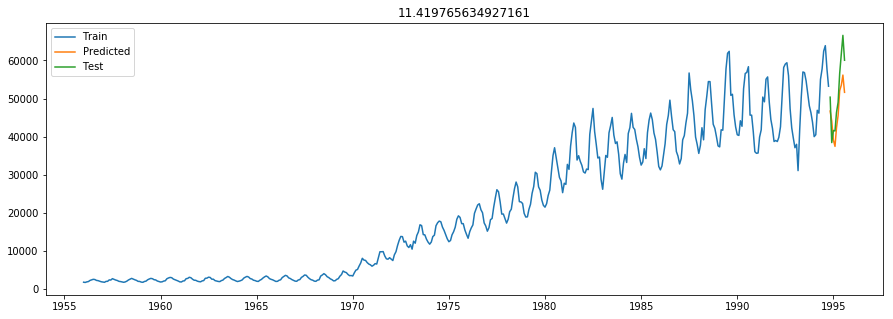

In [5]:
plt.figure(figsize=(15, 5))
plt.plot(gas_train, label='Train')
fc_series = pd.Series(gas_fc)
fc_series.index = gas_test.index
plt.plot(fc_series, label='Predicted')
plt.plot(gas_test, label='Test')
plt.legend()
plt.title(mape(fc_series, gas_test))

In [6]:
def _features_eliminator_builder(num_boost_round, **kwargs):
    return RFECV(XGBRegressor(n_estimators=num_boost_round, **kwargs),
                 scoring='neg_mean_squared_error')

gas_model = ForecastXGB(features_eliminator_builder=_features_eliminator_builder).fit(gas_train, gas_frequency, verbose=False)
gas_fc = gas_model.forecast(10)
print(gas_model.summary)

Importance of features in the xgboost model:
y_lag_12	967246967.1231791
y_lag_11	453442102.4816108
y_lag_24	225413901.99145457
y_lag_1	121812094.12338535
y_lag_23	16678144.223596489


Text(0.5,1,'7.507086324812186')

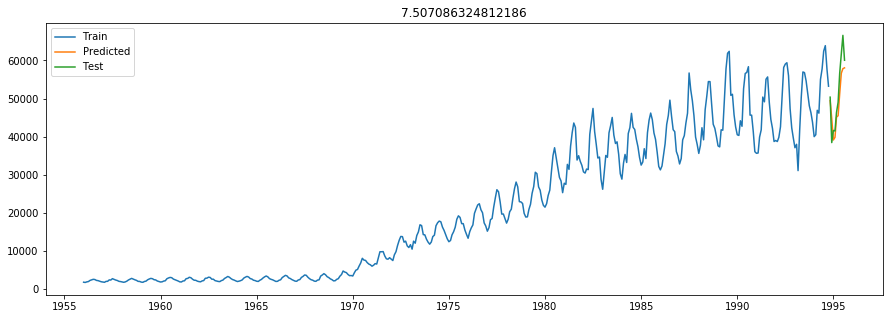

In [7]:
plt.figure(figsize=(15, 5))
plt.plot(gas_train, label='Train')
fc_series = pd.Series(gas_fc)
fc_series.index = gas_test.index
plt.plot(fc_series, label='Predicted')
plt.plot(gas_test, label='Test')
plt.legend()
plt.title(mape(fc_series, gas_test))

In [8]:
usconsumption.head()

consumption    income
year quarter                       
1970 Q1          0.612277  0.496540
     Q2          0.454930  1.736460
     Q3          0.874673  1.344881
     Q4         -0.272514 -0.328146
1971 Q1          1.892187  1.965432

In [9]:
usconsumption['idx'] = list(map(lambda v: ' '.join(map(str,v)), usconsumption.index))
usconsumption.set_index('idx', inplace=True)
usconsumption.head()

,consumption,income
idx,,
1970 Q1,0.612277,0.496540
1970 Q2,0.454930,1.736460
1970 Q3,0.874673,1.344881
1970 Q4,-0.272514,-0.328146
1971 Q1,1.892187,1.965432


In [15]:
usconsumption.tail()

,consumption,income
idx,,
2009 Q4,0.109329,-0.144713
2010 Q1,0.671018,1.187165
2010 Q2,0.717718,1.354355
2010 Q3,0.653143,0.561170
2010 Q4,0.875352,0.371058


In [10]:
income_model = ForecastXGB().fit(usconsumption['income'], usconsumption_frequency, verbose=False)
income_test = pd.DataFrame({
    'income': income_model.forecast(10)
})

In [16]:
consumption_model = ForecastXGB().fit(usconsumption['consumption'], usconsumption_frequency, 
                                      xreg=usconsumption[['income']], 
                                      verbose=False)
consumption_test = pd.DataFrame({
    'consumption': consumption_model.forecast(xreg=income_test)
})
consumption_test.index = [
    '2011 Q1',
    '2011 Q2',
    '2011 Q3',
    '2011 Q4',
    '2012 Q1',
    '2012 Q2',
    '2012 Q3',
    '2012 Q4',
    '2013 Q1',
    '2013 Q2',
]

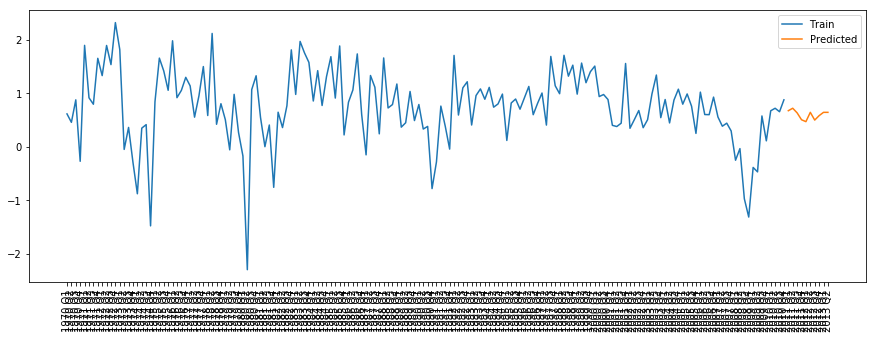

In [17]:
plt.figure(figsize=(15, 5))
plt.plot(usconsumption['consumption'], label='Train')
plt.plot(consumption_test['consumption'], label='Predicted')
plt.xticks(rotation=90)
plt.legend()

In [ ]:
#TODO: make test on last 10 records is source R model